# Metropolis Hastings

## Homework

---

### Q1

Convert your **Gibbs sampler** from the previous homework to be a **Metropolis within Gibbs** sampler.
- Do not derive any full conditionals and instead just use the joint distribution which is the product of the likelihood with the priors
    - Note that in fact you must only be proportional to the joint since irrelevant priors of "the other parameter" will cancel in the ratio
- Note that $\tau$ must be positive so proposals $\tilde \tau$ must also be positive. The easiest way to achieve this would be to use independent samples (that do not depend on $\tau^{(t-1)}$ from exponential, half normal, gamma, or inverse gamma distributions (and other distributions defining strictly positive random variables).
- When considering using independent proposal distributions one option of some note is to use the prior $p(\tau)$ as this proposal distribution

*Clearly articulate your specification and provide a demonstration showing the Bayesian inference it provides, in contrast to that of your previous Gibbs sampler (of Q2 from the last homework).*


In [54]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.tsa.stattools import acf

def joint_posterior(theta, tau, data, theta0, tau0, alpha, lam):
    """
    Computes the unnormalized joint posterior:
    p(theta, tau | x) ∝ p(x | theta, tau) * p(theta) * p(tau)

    Returns:
      posterior_value: unnormalized posterior probability
    """
    n = len(data)
    sum_sq = np.sum((data - theta) ** 2)
    likelihood = tau**(n / 2) * np.exp(-0.5 * tau * sum_sq)
    prior_theta = np.exp(-0.5 * tau0 * (theta - theta0)**2)
    prior_tau = tau**(alpha - 1) * np.exp(-lam * tau)
    return likelihood * prior_theta * prior_tau


def metropolis_within_gibbs(data, theta0, tau0, alpha, lam, n_iter, burn_in, prop_sd_theta):
    """
    Metropolis-within-Gibbs sampling for Normal(mean=theta, precision=tau),
    using direct evaluation of the joint posterior instead of logs.

    Returns:
      (theta_samples, tau_samples): Posterior samples after burn-in
    """
    data = np.asarray(data)

    theta_samples = np.zeros(n_iter)
    tau_samples = np.zeros(n_iter)

    tau_current = np.random.gamma(shape=alpha/2, scale=1/lam/2)
    theta_current = np.random.normal(theta0, 1 / np.sqrt(tau0))

    for t in range(n_iter):
        theta_proposed = np.random.normal(theta_current, prop_sd_theta)

        p_current_theta = joint_posterior(theta_current, tau_current, data, theta0, tau0, alpha, lam)
        p_proposed_theta = joint_posterior(theta_proposed, tau_current, data, theta0, tau0, alpha, lam)

        acceptance_ratio_theta = p_proposed_theta / p_current_theta
        if np.random.rand() < min(1, acceptance_ratio_theta):
            theta_current = theta_proposed

        tau_proposed = np.random.exponential(scale = 2)

        p_current_tau = joint_posterior(theta_current, tau_current, data, theta0, tau0, alpha, lam)
        p_proposed_tau = joint_posterior(theta_current, tau_proposed, data, theta0, tau0, alpha, lam)

        acceptance_ratio_tau = (p_proposed_tau/p_current_tau)*(stats.expon.pdf(tau_current)/stats.expon.pdf(tau_proposed))

        if np.random.rand() < min(1, acceptance_ratio_tau):
            tau_current = tau_proposed

        theta_samples[t] = theta_current
        tau_samples[t] = tau_current

    return theta_samples[burn_in:], tau_samples[burn_in:]


<ipython-input-54-f9392052bcce>:44: RuntimeWarning: invalid value encountered in scalar divide
  acceptance_ratio_theta = p_proposed_theta / p_current_theta
<ipython-input-54-f9392052bcce>:53: RuntimeWarning: invalid value encountered in scalar divide
  acceptance_ratio_tau = (p_proposed_tau/p_current_tau)*(stats.expon.pdf(tau_current)/stats.expon.pdf(tau_proposed))
<ipython-input-54-f9392052bcce>:53: RuntimeWarning: divide by zero encountered in scalar divide
  acceptance_ratio_tau = (p_proposed_tau/p_current_tau)*(stats.expon.pdf(tau_current)/stats.expon.pdf(tau_proposed))


Theta Posterior Mean: 10.02235876555626
Tau Posterior Mean: 0.05048448909757397


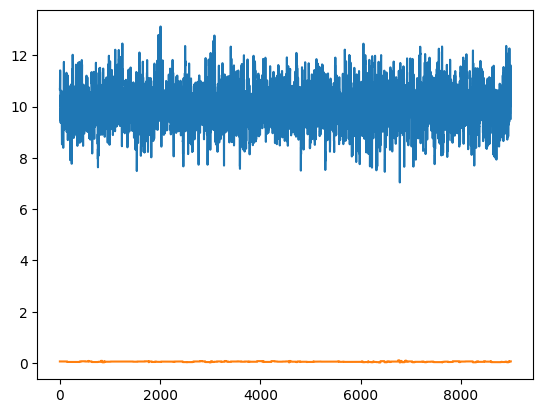

In [55]:
import random

random.seed(888)
np.random.seed(88)

# Synthetic data from Normal(10, 0.05)
true_theta, true_tau = 10, 1/20
data = np.random.normal(true_theta, 1/np.sqrt(true_tau), size=30)

# Prior hyperparameters
theta_prior, tau_prior  = 0.0, 0.01  # Prior mean for theta and tau
alpha, lam  = 1.0, 1.0      # Shape and rate of Gamma prior

theta_samples, tau_samples = metropolis_within_gibbs(
    data, theta_prior, tau_prior, alpha, lam, n_iter=10000, burn_in=1000, prop_sd_theta=1
)

print("Theta Posterior Mean:", np.mean(theta_samples))
print("Tau Posterior Mean:", np.mean(tau_samples))

plt.plot(theta_samples)
plt.plot(tau_samples)

In [56]:
print(np.quantile(theta_samples, [0.025, 0.975]))
print(np.quantile(1/(tau_samples**0.5), [0.025, 0.975]))

[ 8.44102832 11.61569875]
[3.70771536 5.85814318]


Both CI's contain the original values assigned to theta and tau.

### HW3 Gibbs Sampler

In [57]:
def gibbs_normal_gamma(x, alpha, lam, theta0, tau0, n_iter, burn_in):
    """
    Gibbs sampler for a normal(theta, 1/tau) likelihood
    with priors:
      theta ~ Normal(theta0, 1/tau0)
      tau ~ Gamma(alpha, lam)   [shape=alpha, rate=lam]

    Returns:
      (theta_chain, tau_chain) : arrays of posterior samples
    """
    x = np.asarray(x)
    n = len(x)

    # Storage for samples
    theta_samples = np.zeros(n_iter)
    tau_samples = np.zeros(n_iter)

    tau_current = np.random.gamma(alpha, 1/lam)
    theta_current  = np.random.normal(theta0, 1/np.sqrt(tau0))

    for t in range(1,n_iter):
        post_prec = tau_current * n + tau0
        post_mean = (tau_current * n * x.mean() + tau0 * theta0) / post_prec

        theta_current = np.random.normal(loc = post_mean, scale = np.sqrt(1/post_prec))

        post_shape = (alpha + n)*0.5
        sq_resid = np.sum((x - theta_current)**2)
        post_rate = 0.5*(sq_resid + lam)

        tau_current = np.random.gamma(shape=post_shape, scale=1/post_rate)

        theta_samples[t]  = theta_current
        tau_samples[t] = tau_current

    return theta_samples[burn_in:], tau_samples[burn_in:]

In [58]:
random.seed(888)
np.random.seed(88)

# Synthetic data from Normal(10, 0.05)
true_theta, true_tau = 10, 1/20
data = np.random.normal(true_theta, 1/np.sqrt(true_tau), size=30)

# Set prior hyperparameters
theta_prior, tau_prior = 0.0, 0.01      # Prior mean for theta and tau
b = 10       # Laplace prior scale parameter
alpha, lam  = 1.0, 1.0      # Shape and rate of Gamma prior

theta_samples, tau_samples = gibbs_normal_gamma(data, alpha, lam, theta_prior, tau_prior, n_iter = 10000, burn_in = 100)

In [59]:
print("Theta Posterior Mean in simple Gibbs:", np.mean(theta_samples))
print("Tau Posterior Mean in simple Gibb:", np.mean(tau_samples))

Theta Posterior Mean in simple Gibbs: 10.034107224983751
Tau Posterior Mean in simple Gibb: 0.04833618850456534


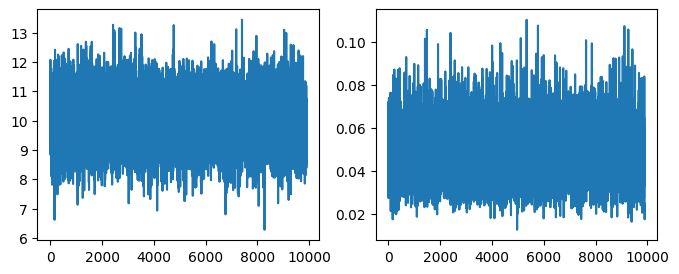

In [60]:
fig,ax = plt.subplots(1,2,figsize=(8,3))
ax[0].plot(theta_samples)
ax[1].plot(tau_samples)

In [61]:
print(np.quantile(theta_samples, [0.025, 0.975]))
print(np.quantile(1/(tau_samples**0.5), [0.025, 0.975]))

[ 8.34215433 11.71734024]
[3.64729614 6.07822938]


### Comparison

Both quantiles in the metropolis within gibbs sampler and original gibbs sampler contain the theta and tau values correctly. The difference between the credible intervals is that metropolis within gibbs provides narrower intervals. On the one hand, the requirement of a proposal distribution in Metropolis-Hastings can introduce more components for which to account. These components include the sometimes challenging task of defining a proposal distribution in high-dimensional spaces and ensuring the proposal distribution is well-tuned (through hyperparameters) to the target distribution. On the other hand, for Metropolis Hastings can be used to sample from any distribution as long as we can compute the target distribution's likleihood whereas gibbs requires us to be able to sample from the full conditional distributions of each variable in the model.

Altogether, it depends on the information we have about the target distribution's likelihood and/or full conditional distributions of each variable which will be the defining factor in choosing between using Metropolis Hastings or simple Gibbs sampling.


### Q2

Adjust your **Metropolis within Gibbs** sampler as follows.

- Use the following **dependent** proposal for $\tau$

```Python
stats.truncnorm(a=-tau_t_minus_1/s, b=np.inf,
                loc=tau_t_minus_1, scale=s)
```

- Use a prior for $\theta$ that is not a normal distribution


*Provide a demonstration showing the Bayesian inference provided by this sampler. Then discuss the necessity (or lackthereof) of analytically determining the full conditional distributions when performing Gibbs sampling.*

In [62]:
def joint_posterior(theta, tau, data, theta0, b, alpha, lam):
    """
    Computes the unnormalized joint posterior:
    p(theta, tau | x) ∝ p(x | theta, tau) * p(theta) * p(tau)

    Returns:
      posterior_value: unnormalized posterior probability
    """
    n = len(data)
    sum_sq = np.sum((data - theta) ** 2)
    likelihood = tau**(n/2) * np.exp(-0.5 * tau * sum_sq)
    prior_theta = np.exp(-np.abs(theta - theta0)/b)
    prior_tau = tau**(alpha - 1) * np.exp(-lam * tau)
    return likelihood * prior_theta * prior_tau

def metropolis_within_gibbs(data, theta0, b, alpha, lam, n_iter, burn_in, prop_sd_theta, s):
    """
    Metropolis-within-Gibbs sampling for Normal(mean=theta, precision=tau),
    using direct evaluation of the joint posterior instead of logs.

    Returns:
      (theta_samples, tau_samples): Posterior samples after burn-in
    """
    data = np.asarray(data)
    theta_samples = np.zeros(n_iter)
    tau_samples = np.zeros(n_iter)
    tau_current = np.random.gamma(shape=alpha, scale=1/lam)
    theta_current = np.random.laplace(theta0, b)

    for t in range(n_iter):
        theta_proposed = np.random.normal(theta_current, prop_sd_theta)

        p_current_theta = joint_posterior(theta_current, tau_current, data, theta0, b, alpha, lam)
        p_proposed_theta = joint_posterior(theta_proposed, tau_current, data, theta0, b, alpha, lam)

        acceptance_ratio_theta = p_proposed_theta / p_current_theta
        if np.random.rand() < min(1, acceptance_ratio_theta):
            theta_current = theta_proposed

        tau_proposed = stats.truncnorm.rvs(a=-tau_current/s, b=np.inf, loc=tau_current, scale=s)

        p_current_tau = joint_posterior(theta_current, tau_current, data, theta0, b, alpha, lam)
        p_proposed_tau = joint_posterior(theta_current, tau_proposed, data, theta0, b, alpha, lam)

        acceptance_ratio_tau = (p_proposed_tau/p_current_tau)*\
                               (stats.truncnorm.pdf(tau_current, a=-tau_proposed/s, b=np.inf, loc=tau_proposed, scale=s)/\
                                stats.truncnorm.pdf(tau_proposed, a=-tau_current/s, b=np.inf, loc=tau_current, scale=s))

        if np.random.rand() < min(1, acceptance_ratio_tau):
            tau_current = tau_proposed

        theta_samples[t] = theta_current
        tau_samples[t] = tau_current

    # Discard burn-in
    return theta_samples[burn_in:], tau_samples[burn_in:]

In [64]:
# Synthetic data from Normal(10, 0.05)
true_theta, true_tau = 10, 1/20
data = np.random.normal(true_theta, 1/np.sqrt(true_tau), size=30)

# Set prior hyperparameters
theta_prior = 0.0      # Prior mean for theta
b = 10
alpha, lam  = 1.0, 1.0   # Shape and rate of Gamma prior

theta_samples, tau_samples = metropolis_within_gibbs(
    data, theta_prior , b, alpha, lam, n_iter=10000, burn_in=500, prop_sd_theta=1, s=0.5
)

Posterior mean of theta: 7.860180607559916
Posterior mean of tau: 0.06742739147593169


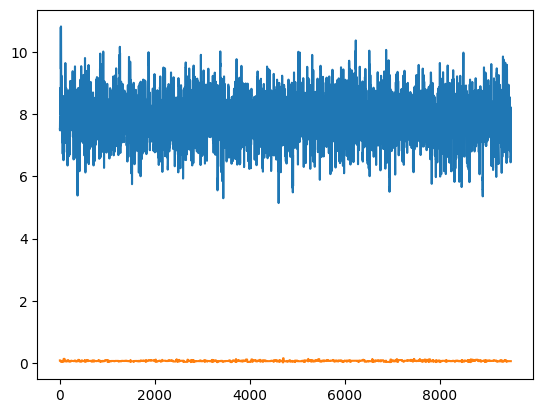

In [65]:
print("Posterior mean of theta:", np.mean(theta_samples))
print("Posterior mean of tau:", np.mean(tau_samples))

plt.plot(theta_samples)
plt.plot(tau_samples)

In [66]:
print(np.quantile(theta_samples, [0.025, 0.975]))
print(np.quantile(1/(tau_samples**0.5), [0.025, 0.975]))

[6.4117451  9.29615666]
[3.07561169 5.23698258]


### Necessity of Analytical Full Conditional Distributions for Gibbs Sampling

Analytical full conditionals are the preferred scenario for Gibbs sampling because they allow for exact sampling in each step of the chain without approximation. When the full conditionals are easy to derive, Gibbs sampling becomes highly efficient and straightforward. The algorithm simply samples from the exact distribution for each variable, one at a time, while holding the others fixed.


Gibbs sampling does not require the full conditional distributions to be analytically tractable, but it does require the ability to sample from these conditionals. If analytical conditionals are not available, approximate sampling methods may be used. This is where Metropolis-within-Gibbs comes in. If the full conditional is complex and not analytically tractable, one can use Metropolis-Hastings within each Gibbs sampling iteration. This involves proposing a new value for a variable using a proposal distribution, and then accepting or rejecting that proposal based on the target conditional distribution.



### Q3

For **Metropolis Hastings** targetting (**stationary distribution**) $p$ based on proposal distribuiton $q$ given below

$\begin{align}
q(\tilde x^{(t)} | x^{(t-1)}) &={} \left(\frac{1}{2}\right)^{1-{\tilde x^{(t)}}}\left(\frac{1}{2}\right)^{\tilde x^{(t)}} \quad \color{gray}{\textrm{ ... does } \quad \frac{q(x^{(t-1)}|\tilde x^{(t)})}{q(\tilde x^{(t)}|x^{(t-1)})} \quad  \textrm{ cancel?}}\\
\textrm{and} \quad p(x^{(t)}) &={} \left(\frac{1}{3}\right)^{1-{x^{(t)}}}\left(\frac{2}{3}\right)^{x^{(t)}}\\
\end{align}$

<u>show that</u> the **transition kernel** $K$ of transition probabilities is defined the **Metropolis Hastings** algorithm is

$K = \left[\begin{array}{cc}\Pr(x^{(t)}=0 \rightarrow x^{(t+1)}=0) & \Pr(x^{(t)}=1 \rightarrow x^{(t+1)}=0)\\\Pr(x^{(t)}=0 \rightarrow x^{(t+1)}=1)& \Pr(x^{(t)}=1 \rightarrow x^{(t+1)}=1)\end{array}\right] = \left[\begin{array}{cl} 0.5 & 0.25 \\ 0.5 & 0.75 \end{array}\right]$

> For example
>
> $\begin{align}
\Pr(s_1 \rightarrow s_1) &={}
q(\tilde x^{(t)}=1 | x^{(t-1)}=1) + q(\tilde x^{(t)}=0 | x^{(t-1)}=1) \left(1- \frac{p(\tilde x^{(t)}=0)}{p(x^{(t-1)}=1)}\right)\\
&={} 1/2 + (1/2)(1-(1/3)/(2/3)) = 0.75
\end{align}$



#### Given:
1. **Proposal distribution**:

   $
   q(\tilde x^{(t)} | x^{(t-1)}) =
   \begin{cases}
   1/2 & \text{for } \tilde x^{(t)} = 0 \text{ or } 1, \\
   0 & \text{otherwise.}
   \end{cases}
   $

   This is symmetric as $ q(\tilde x^{(t)} | x^{(t-1)}) = q(x^{(t-1)} | \tilde x^{(t)}) $.

2. **Target stationary distribution**:

   $
   p(x^{(t)}) =
   \begin{cases}
   1/3 & \text{for } x^{(t)} = 0, \\
   2/3 & \text{for } x^{(t)} = 1.
   \end{cases}
   $

3. **Acceptance probability**:

   The acceptance probability for moving from $ x^{(t-1)} $ to $ \tilde x^{(t)} $ is given by:

   $
   A(x^{(t-1)}, \tilde x^{(t)}) = \min\left(1, \frac{p(\tilde x^{(t)})}{p(x^{(t-1)})}\right)
   $

---

### Transition Kernel Computation

The general form for the transition probability $\Pr(x^{(t-1)} \rightarrow x^{(t)}) $ is:

$
\Pr(x^{(t-1)} \rightarrow x^{(t)}) =
q(\tilde x^{(t)} | x^{(t-1)}) \cdot A(x^{(t-1)}, \tilde x^{(t)}).
$

#### Case 1: $ x^{(t-1)} = 0 $
1. **Proposal to $ \tilde x^{(t)} = 1 $**:

   $
   q(1 | 0) = 1/2, \quad p(1) = 2/3, \quad p(0) = 1/3.
  $

   The acceptance probability is:

   $
   A(0, 1) = \min\left(1, \frac{p(1)}{p(0)}\right) = \min\left(1, \frac{2/3}{1/3}\right) = 1.
   $

   Thus:

   $
   \Pr(0 \rightarrow 1) = q(1 | 0) \cdot A(0, 1) = (1/2) \cdot 1 = 1/2.
   $

2. **Stay at $ x^{(t)} = 0 $**:
   The probability of staying at $ x^{(t)} = 0 $ is the complement of moving to $x^{(t)} = 1 $:

   $
   \Pr(0 \rightarrow 0) = 1 - \Pr(0 \rightarrow 1) = 1 - 1/2 = 1/2.
   $

---

#### Case 2: $ x^{(t-1)} = 1 $
1. **Proposal to $ \tilde x^{(t)} = 0 $**:

   $
   q(0 | 1) = 1/2, \quad p(1) = 2/3, \quad p(0) = 1/3.
   $

   The acceptance probability is:

   $
   A(1, 0) = \min\left(1, \frac{p(0)}{p(1)}\right) = \min\left(1, \frac{1/3}{2/3}\right) = 1/2.
   $

   Thus:

   $
   \Pr(1 \rightarrow 0) = q(0 | 1) \cdot A(1, 0) = (1/2) \cdot (1/2) = 1/4.
   $

2. **Stay at $x^{(t)} = 1 $**

   The probability of staying at $ x^{(t)} = 1 $ is the complement of moving to $ x^{(t)} = 0 $:

   $
   \Pr(1 \rightarrow 1) = 1 - \Pr(1 \rightarrow 0) = 1 - 1/4 = 3/4.
   $

---

### Final Transition Kernel

Combining the results, the transition kernel $ K $ is:

$ K =
\begin{bmatrix}
\Pr(0 \rightarrow 0) & \Pr(1 \rightarrow 0) \\
\Pr(0 \rightarrow 1) & \Pr(1 \rightarrow 1)
\end{bmatrix}
=
\begin{bmatrix}
0.5 & 0.25 \\
0.5 & 0.75
\end{bmatrix}$



